# **Önişleme**



0-Veri Seti indirme ve inceleme

In [16]:

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

import os
import librosa
import librosa.display
import glob 
import skimage

In [35]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2022-10-05 18:40:09--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  5.36MB/s    in 8m 3s   

2022-10-05 18:48:14 (11.9 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [3]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [4]:
data= pd.read_csv("/content/UrbanSound8K/metadata/UrbanSound8K.csv")

In [5]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
data["fold"].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

In [9]:
audio_path = "/content/UrbanSound8K/audio/"
audio_clips = os.listdir(audio_path)
print("No. of .wav files in audio folder = ",len(audio_clips))


No. of .wav files in audio folder =  11


In [18]:
dat1, sampling_rate1 = librosa.load('/content/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('/content/UrbanSound8K/audio/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Dat1 visualisation')

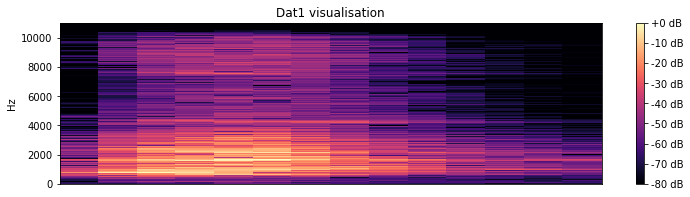

In [23]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.title('Dat1 visualisation')

Text(0.5, 1.0, 'Dat 2 visualisation')

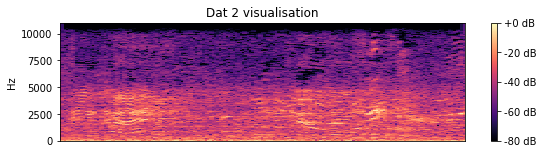

In [24]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Dat 2 visualisation')

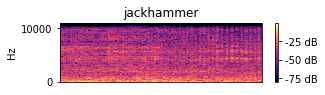

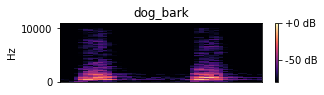

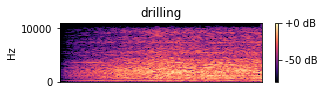

In [26]:

arr = np.array(data["slice_file_name"])
fold = np.array(data["fold"])
cla = np.array(data["class"])

for i in range(192, 197, 2):
    path = '/content/UrbanSound8K/audio/fold' + str(fold[i]) + '/' + arr[i]
    dt, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(dt)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [27]:
dat1, sampling_rate1 = librosa.load('/content/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [28]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = '/content/UrbanSound8K/audio/fold' + str(data["fold"][i]) + '/' + data["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(data["classID"][i])
    return [feature, label]

In [30]:
temp = parser(data)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [31]:
temp = np.array(temp)
dataset = temp.transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [32]:
X_ = dataset[:, 0]
Y = dataset[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [33]:
for i in range(8732):
    X[i] = (X_[i])

In [36]:
Y = to_categorical(Y)

In [37]:
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [39]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [40]:
input_dim = (16, 8, 1)

##**Model Hazırlanması ve Eğitimi**

In [41]:
model = Sequential()

In [42]:
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [43]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [65]:
results= model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
131/131 [==============================] - 1s 6ms/step - loss: 0.0191 - accuracy: 0.9942 - val_loss: 1.0612 - val_accuracy: 0.8823
Epoch 2/90
131/131 [==============================] - 1s 5ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 1.0646 - val_accuracy: 0.8795
Epoch 3/90
131/131 [==============================] - 1s 5ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 1.0716 - val_accuracy: 0.8859
Epoch 4/90
131/131 [==============================] - 1s 5ms/step - loss: 0.0080 - accuracy: 0.9968 - val_loss: 1.0193 - val_accuracy: 0.8859
Epoch 5/90
131/131 [==============================] - 1s 5ms/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 1.0234 - val_accuracy: 0.8864
Epoch 6/90
131/131 [==============================] - 1s 5ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 1.0069 - val_accuracy: 0.8846
Epoch 7/90
131/131 [==============================] - 1s 5ms/step - loss: 0.0090 - accuracy: 0.9966 - val_loss: 1.0041 - val_accuracy: 0.8846
Epoch 

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 128)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [52]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 0s 3ms/step - loss: 0.8758 - accuracy: 0.8621
[0.875819742679596, 0.8621163368225098]


In [53]:
preds = np.argmax(predictions, axis = 1)

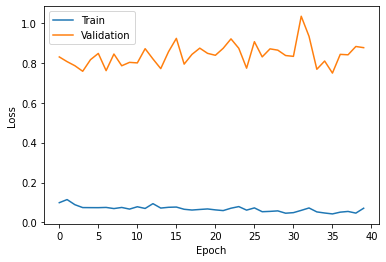

In [54]:
# Plot the the training loss
plt.plot(results.history["loss"],label="Train")

# Plot the the validation loss
plt.plot(results.history["val_loss"],label="Validation")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Put legend table
plt.legend()

# Show the plot
plt.show()

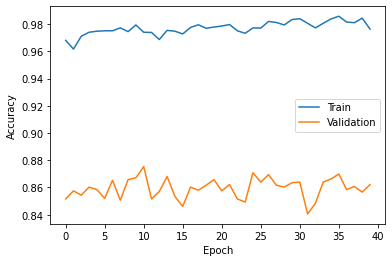

In [55]:
# Plot the the training accuracy
plt.plot(results.history["accuracy"],label="Train")

# Plot the the validation accuracy
plt.plot(results.history["val_accuracy"],label="Validation")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# Put legend table
plt.legend()

# Show the plot
plt.show()

epoch sayısını 40'tan 90'a yükselttim

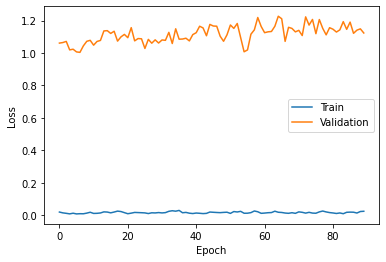

In [68]:
# Plot the the training loss
plt.plot(results.history["loss"],label="Train")

# Plot the the validation loss
plt.plot(results.history["val_loss"],label="Validation")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Put legend table
plt.legend()

# Show the plot
plt.show()

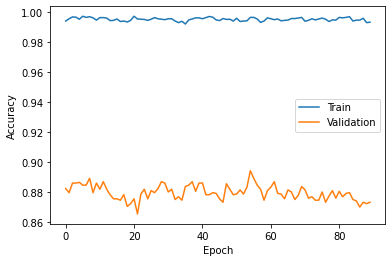

In [67]:
# Plot the the training accuracy
plt.plot(results.history["accuracy"],label="Train")

# Plot the the validation accuracy
plt.plot(results.history["val_accuracy"],label="Validation")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# Put legend table
plt.legend()

# Show the plot
plt.show()